Import

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
my_SIFT_instance = cv2.SIFT_create()
cf = cv2.imread("computers_left.png")
cf = cv2.cvtColor(cf,cv2.COLOR_BGR2RGB)
cr = cv2.imread("computers_right.png")
cr = cv2.cvtColor(cr,cv2.COLOR_BGR2RGB)
dfl = cv2.imread("daft_punk_left.jpg")
dfl = cv2.cvtColor(dfl,cv2.COLOR_BGR2RGB)
dfr = cv2.imread("daft_punk_right.jpg")
dfr = cv2.cvtColor(dfr,cv2.COLOR_BGR2RGB)

1.1

Text(0.5, 1.0, 'Right')

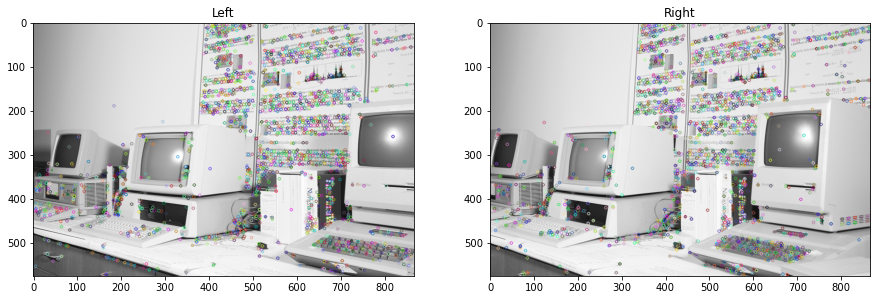

In [2]:
def loweratiomatch(img1,img2):
    kp1, des1 = my_SIFT_instance.detectAndCompute(img1,None)
    kp2, des2 = my_SIFT_instance.detectAndCompute(img2,None)
    fbm = cv2.FlannBasedMatcher()
    matches = fbm.knnMatch(des1,des2, k=2)
    good = []
    goodlist=[]
    pts1 = []
    pts2 = []
    for m,n in matches:
        if(m.distance < 0.8*n.distance):
            good.append([m])
            goodlist.append(m)
            pts1.append(kp1[m.queryIdx].pt)  
            pts2.append(kp2[m.trainIdx].pt)

    return kp1,kp2,des1,des2,good,goodlist,pts1,pts2
rescf = np.copy(cf)
rescr = np.copy(cr)

cfgray = cv2.cvtColor(rescf,cv2.COLOR_BGR2GRAY)
crgray = cv2.cvtColor(rescr,cv2.COLOR_BGR2GRAY)
kp1,kp2,des1,des2,good,goodlist,pts1,pts2 = loweratiomatch(cf,cr)
cfkp = cv2.drawKeypoints(cfgray,kp1,cfgray)
crkp = cv2.drawKeypoints(crgray,kp2,crgray)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(cfkp)
plt.title('Left')
plt.subplot(1,2,2)
plt.imshow(crkp)
plt.title('Right')

1.2

Text(0.5, 1.0, 'computers_right')

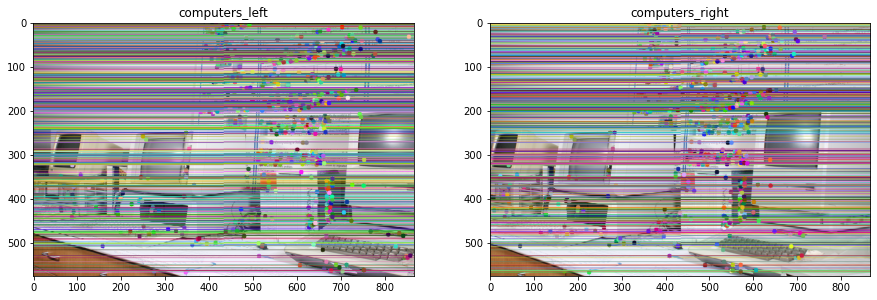

In [3]:
def drawlines(img, lines, leftpoint, rightpoint,flag):
    col = img.shape[1]
    res = np.copy(img)
    color = (0,255,0)
    for line, lpt in zip(lines, leftpoint):
        line = line[0]
 
        x1,y1 = [0, int(-line[2]/line[1])]  #NOTE: calculate bound points 
        x2,y2 = [col, int(-(line[2]+line[0]*col)/line[1])]
        if flag == 1:
            color = tuple(np.random.randint(0,255,size = 3).tolist())
            res = cv2.circle(res, tuple(lpt[0]), 5, color, -1)
        res = cv2.line(res, (x1,y1), (x2,y2), color,thickness = 1)
    return res


def Calepipolarline(img1, img2):
    point1 = []
    point2 = []
    pltImage1 = []
    kp1,kp2,des1,des2,good,goodlist,point1,point2 = loweratiomatch(img1,img2)
    point1 = np.int32(point1)
    point2 = np.int32(point2)
    F, mask = cv2.findFundamentalMat(point1, point2, cv2.FM_LMEDS)
    
    point1 = point1[mask.reshape(-1)==1].reshape(-1,1,2)   
    point2 = point2[mask.reshape(-1)==1].reshape(-1,1,2)
    
    lines1 = cv2.computeCorrespondEpilines(point2, 2, F)
    lines2 = cv2.computeCorrespondEpilines(point1, 1, F)
    outimg1 = drawlines(img1, lines1, point1, point2 , 1)
    outimg2 = drawlines(img2, lines2, point2, point1, 1)
    
    return outimg1, outimg2

cf1,cr1 = Calepipolarline(cf, cr)
computer = np.concatenate((cf1, cr1), axis=1)
cv2.imshow("computer_output",computer)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(cf1)
plt.title("computers_left")
plt.subplot(1,2,2)
plt.imshow(cr1)
plt.title("computers_right")

Text(0.5, 1.0, 'daft_punk_right')

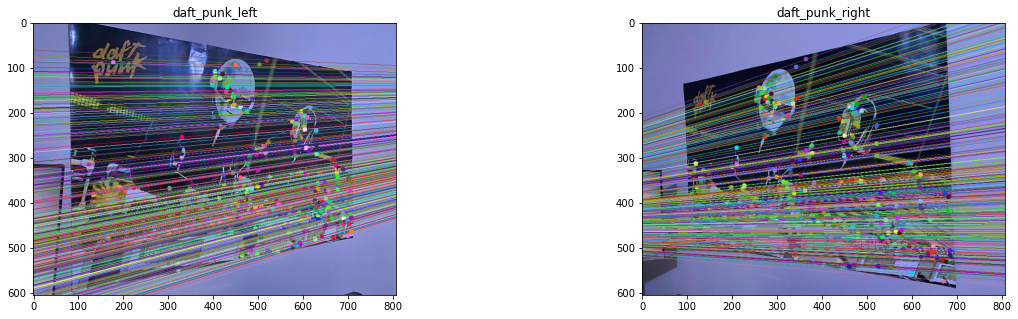

In [4]:
dfl1,dfr1 = Calepipolarline(dfl, dfr)
daft = np.concatenate((dfl1, dfr1), axis=1)
cv2.imshow("daft_punk_output",daft)
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(dfl1)
plt.title("daft_punk_left")
plt.subplot(1,2,2)
plt.imshow(dfr1)
plt.title("daft_punk_right")

1.3

In [5]:
def PointConjugateEpipolarLine_l_to_r(event,  x,  y,  flags,  param):
    if event == cv2.EVENT_LBUTTONUP:
        cv2.destroyAllWindows()
        _img1 = param[0]
        _img2 = param[1]
        pointIdx = [x,y]
        kp1,kp2,des1,des2,good,goodlist,point1,point2 = loweratiomatch(_img1,_img2)
        point1 = np.int32(point1)
        point2 = np.int32(point2)
        F, mask = cv2.findFundamentalMat(point1, point2, cv2.FM_LMEDS)     
        point1[-1] = pointIdx 
        lines = [cv2.computeCorrespondEpilines(point1, 1, F)[-1]]
        outImg1 = cv2.circle(_img1, tuple(pointIdx), 5, (0,255,0), -1)
        outImg2 = drawlines(_img2, lines, point2,point1, 0)
        cv2.imshow("right_left_point_to_right_line",outImg2)
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.imshow(outImg1)
        plt.title("daft punk left")
        plt.subplot(1,2,2)
        plt.imshow(outImg2)
        plt.title("daft punk right")

def PointConjugateEpipolarLine_r_to_l(event,  x,  y,  flags,  param):
    if event == cv2.EVENT_LBUTTONUP:
        cv2.destroyAllWindows()
        _img1 = param[0]
        _img2 = param[1]
        pointIdx = [x,y]
        kp1,kp2,des1,des2,good,goodlist,point1,point2 = loweratiomatch(_img1,_img2)
        point1 = np.int32(point1)
        point2 = np.int32(point2)
        F, mask = cv2.findFundamentalMat(point1, point2, cv2.FM_LMEDS)     
        point1[-1] = pointIdx 
        lines = [cv2.computeCorrespondEpilines(point1, 1, F)[-1]]
        outImg1 = cv2.circle(_img1, tuple(pointIdx), 5, (0,255,0), -1)
        outImg2 = drawlines(_img2, lines, point2,point1, 0)
        cv2.imshow("left_right_point_to_left_line",outImg2)
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.imshow(outImg1)
        plt.title("daft punk right")
        plt.subplot(1,2,2)
        plt.imshow(outImg2)
        plt.title("daft punk left")


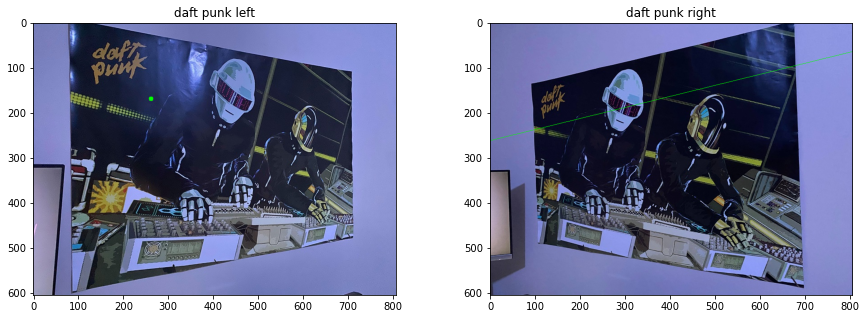

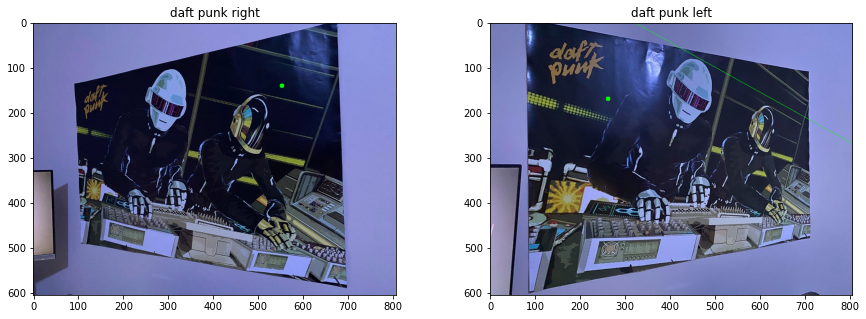

In [6]:
while True:
    cv2.imshow("1.3 Input_left", dfl)
    cv2.imshow("1.3 Input_right", dfr)
    cv2.setMouseCallback("1.3 Input_left",PointConjugateEpipolarLine_l_to_r,[dfl, dfr])
    cv2.setMouseCallback("1.3 Input_right",PointConjugateEpipolarLine_r_to_l,[dfr, dfl])
    k = cv2.waitKey(1)
    if k == 27:
        break              #press esc to close the window and show the reults below
cv2.destroyAllWindows()